# Bikes Linear Regression Project

Goal: Predict the **total count of bikes rented during each hour** covered by the test set, using only information available prior to the rental period. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

In [2]:
train = pd.read_csv('../data/train.csv')

In [3]:
train.sample()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10836,2012-12-17 22:00:00,4,0,1,2,17.22,21.21,94,8.9981,5,49,54


#### Data wrangling

In [440]:
# Convert 'datetime' column into pandas datetime dtype
train['datetime'] = pd.to_datetime(train['datetime'], dayfirst=True)

In [5]:
# Create new columns to extract hour, weekday, month and year
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday
train['month'] = train['datetime'].dt.month
train['year'] = train['datetime'].dt.year

#### Split data into train and test sets 

In [6]:
# Drop datetime column as this will cause errors.
X = train.drop(['count', 'casual', 'registered', 'datetime'], axis=1)
y = train['count']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
train.shape, X_train.shape, X_test.shape

((10886, 16), (8708, 12), (2178, 12))

#### Make custom scorer

In [9]:
# Note: Root mean squared log error penalizes underestimating more than an overestimating
def rmsle(y, y_pred):
    y_pred[y_pred < 0] = 0
    return metrics.mean_squared_log_error(y, y_pred)**0.5

In [10]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

#### Baseline models

In [209]:
# Baseline 1
m_base1 = DummyRegressor().fit(X_train, y_train)
y_base1_pred = m_base1.predict(X_train)
rmsle(y_train, y_base1_pred)

1.56709801819398

In [210]:
# Baseline 2
m_base2 = LinearRegression().fit(X_train, y_train)
y_base2_pred = m_base2.predict(X_train)
rmsle(y_train, y_base2_pred)

1.3050330488646187

In [232]:
dummy_coefs = pd.DataFrame((zip(m_base2.coef_, X_train.columns)), columns=['coef', 'feature']).sort_values('coef', ascending=False)
dummy_coefs.head(5)
# Top 5 features used are year, month, hour, atemp and workingday

,coef,feature
11,80.347586,year
10,10.888387,month
8,7.861619,hour
5,4.531793,atemp
2,2.420363,workingday
4,1.822407,temp


#### Make new DataFrame and categories to get overview of training set

In [233]:
X_all = X_train.merge(y_train, how='outer', left_index=True, right_index=True)
X_all.head(2);

In [234]:
# Make data categories based on workingday or free day(weekend/holiday)
freeday = X_all[X_all['workingday'] == 0]
workday = X_all[X_all['workingday'] == 1]

In [236]:
# Make data categories based on season
spring = X_all[X_all['season'] == 1]
summer = X_all[X_all['season'] == 2]
fall = X_all[X_all['season'] == 3]
winter = X_all[X_all['season'] == 4]

#### Visualize relationships

<AxesSubplot:>

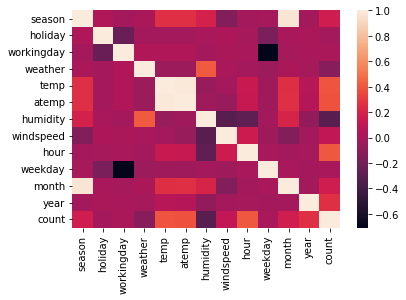

In [176]:
sns.heatmap(X_all.corr())

In [441]:
# Check for best correlation values 
X_all.corr().applymap(lambda val: val if abs(val) > 0.2 else '')
# High correlation between atemp and temp - selecting atemp
# High positive correlation between atemp and count
# High correlation between hour and count
# High negative correlation between humidity and count

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year,count
season,1.0,,,,0.253543,0.258779,,,,,0.97149,,
holiday,,1.0,-0.24689,,,,,,,,,,
workingday,,-0.24689,1.0,,,,,,,-0.709079,,,
weather,,,,1.0,,,0.407489,,,,,,
temp,0.253543,,,,1.0,0.983881,,,,,0.251904,,0.38967
atemp,0.258779,,,,0.983881,1.0,,,,,0.257265,,0.384758
humidity,,,,0.407489,,,1.0,-0.315843,-0.283453,,0.204318,,-0.321606
windspeed,,,,,,,-0.315843,1.0,,,,,
hour,,,,,,,-0.283453,,1.0,,,,0.40366
weekday,,,-0.709079,,,,,,,1.0,,,


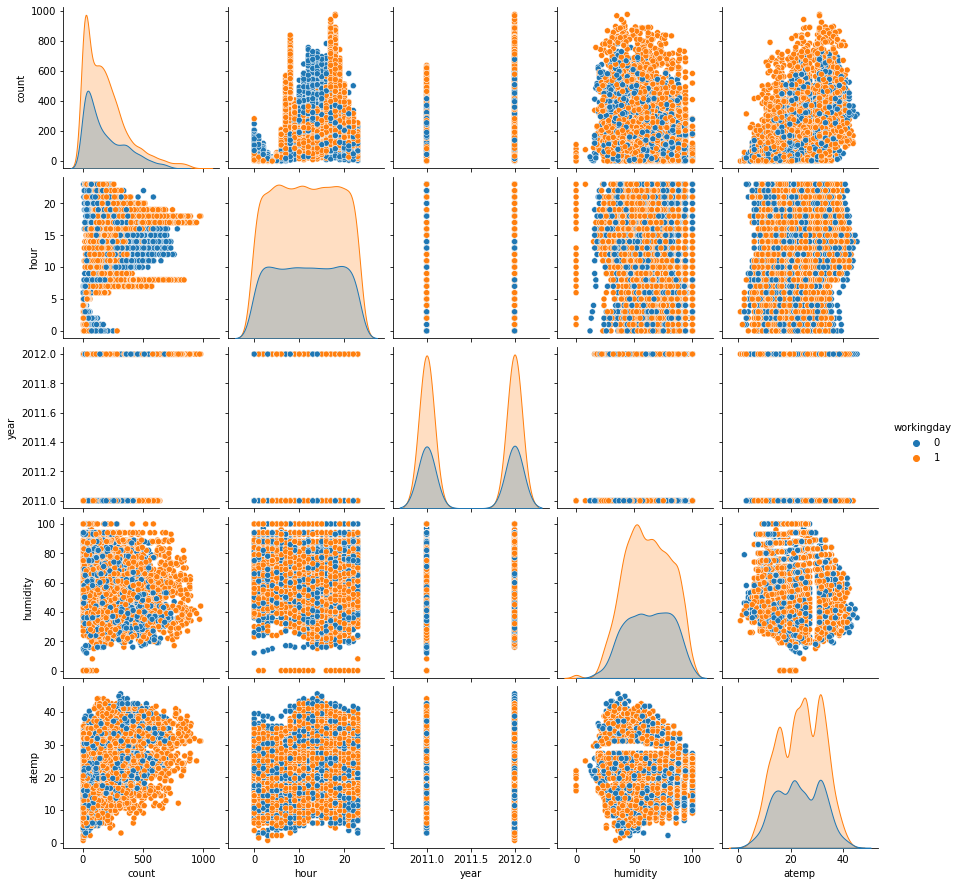

In [252]:
overview = X_all[['count', 'hour', 'year', 'humidity', 'atemp', 'workingday']]
sns.pairplot(data=overview, hue='workingday')

<AxesSubplot:xlabel='hour', ylabel='count'>

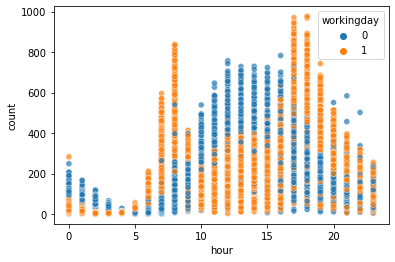

In [255]:
sns.scatterplot(data=train, x='hour', y='count', hue='workingday', alpha=0.7)

<AxesSubplot:xlabel='hour', ylabel='count'>

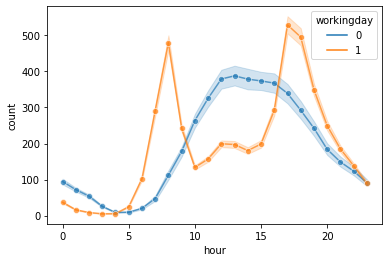

In [271]:
sns.lineplot(data=train, x='hour', y='count', hue='workingday', alpha=0.7, marker='o')
# Start the plot from 5 - when people's day starts

<AxesSubplot:xlabel='hour', ylabel='count'>

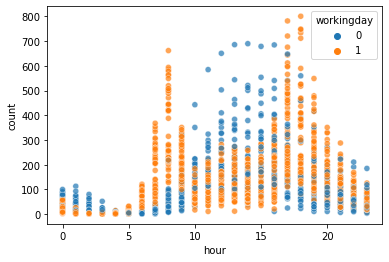

In [274]:
sns.scatterplot(data=spring, x='hour', y='count', hue='workingday', alpha=0.7)
# There seem to be some outliers on non-work days in spring - why is this?

<AxesSubplot:xlabel='hour', ylabel='count'>

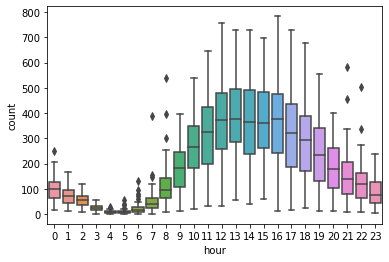

In [33]:
sns.boxplot(data=freeday, x='hour', y='count')

<AxesSubplot:xlabel='hour', ylabel='count'>

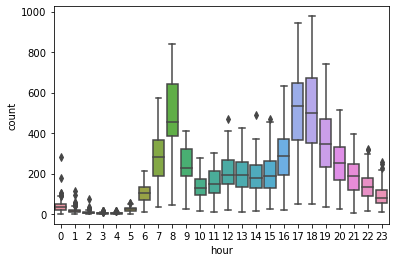

In [34]:
sns.boxplot(data=workday, x='hour', y='count')
#There's clear chunks of hours with different upward and downward trends (depending also on workday or freeday)

#### Feature engineering pipeline for LinearRegression model

In [376]:
scaler_and_pf = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(include_bias=False)
)

In [377]:
transformer_reg = ColumnTransformer([
    ('one-hot', OneHotEncoder(), ['hour', 'year']),
    ('scaling', scaler_and_pf, ['atemp', 'humidity']),
    ('do-nothing', 'passthrough', ['workingday'])
])

In [378]:
from sklearn import set_config
set_config(display='diagram')
transformer_reg

ColumnTransformer(transformers=[('one-hot', OneHotEncoder(), ['hour', 'year']),
                                ('scaling',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['atemp', 'humidity']),
                                ('do-nothing', 'passthrough', ['workingday'])])

In [379]:
transformer_reg.fit_transform(X_train).shape

(8708, 32)

#### LinearRegression model

In [380]:
m_reg = make_pipeline(
    transformer_reg,
    Ridge()
)
m_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                                  ['hour', 'year']),
                                                 ('scaling',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['atemp', 'humidity']),
                                                 ('do-nothing', 'passthrough',
                                                  ['workingday'])])),
                ('ridge', Ridge())])

In [381]:
m_reg.fit(X_train, y_train)
y_reg_train_pred = m_reg.predict(X_train)
rmsle(y_train, y_reg_train_pred)

1.1266767267700493

In [382]:
y_reg_test_pred = m_reg.predict(X_test)
rmsle(y_test, y_reg_test_pred)

1.1297119355563223

#### Optimize hyperparameters for LinearRegression model

In [308]:
m_reg.get_params();

In [365]:
# Define hyperparamaters to use and with which values to try
parameters_reg = {'columntransformer__scaling__polynomialfeatures__degree': [2, 3],
                  'columntransformer__scaling__polynomialfeatures__interaction_only': [True, False],
                  'ridge__alpha': [158, 160, 162, 164, 168]           
}

#### Grid search to optimize hyperparameters

In [366]:
gridsearch_reg = GridSearchCV(
            estimator = m_reg,
            param_grid = parameters_reg, 
            cv = 5, 
            return_train_score = True,
            scoring = rmsle_scorer, 
            n_jobs = -1)

In [367]:
gridsearch_reg.fit(X_train, y_train);

In [368]:
gridsearch_reg.cv_results_.keys();

In [369]:
cols_reg = ['param_columntransformer__scaling__polynomialfeatures__degree',
            'param_columntransformer__scaling__polynomialfeatures__interaction_only',
            'param_ridge__alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score'
]

In [370]:
gridsearch_reg_df = pd.DataFrame(gridsearch_reg.cv_results_)

In [371]:
gridsearch_reg_df[cols_reg];

In [372]:
# Get optimized hyperparameter values
gridsearch_reg.best_params_

{'columntransformer__scaling__polynomialfeatures__degree': 2,
 'columntransformer__scaling__polynomialfeatures__interaction_only': True,
 'ridge__alpha': 158}

#### LinearRegression model w/ optimized hyperparameters

In [384]:
scaler_and_pf_optimized = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

In [385]:
transformer_reg_optimized = ColumnTransformer([
    ('one-hot', OneHotEncoder(), ['hour', 'year']),
    ('scaling', scaler_and_pf, ['atemp', 'humidity']),
    ('do-nothing', 'passthrough', ['workingday'])
])

In [389]:
m_reg_optimized = make_pipeline(
    transformer_reg_optimized,
    Ridge(alpha=158)
)

In [390]:
m_reg_optimized.fit(X_train, y_train)
y_reg_train_pred = m_reg_optimized.predict(X_train)
rmsle(y_train, y_reg_train_pred)

1.067414980570336

In [391]:
y_reg_test_pred = m_reg_optimized.predict(X_test)
rmsle(y_test, y_reg_test_pred)

1.074888217279252

#### Feature engineering for RandomForestRegressor model

In [392]:
scaler = make_pipeline(
        MinMaxScaler()
)

In [393]:
transformer_rf = ColumnTransformer([
    ('one-hot', OneHotEncoder(), ['hour', 'weekday', 'month', 'year']),
    ('scaling', scaler, ['atemp', 'humidity']),
    ('do-nothing', 'passthrough', ['workingday'])
])

#### RandomForestRegressor model

In [394]:
m_rfr = make_pipeline(
    transformer_rf,
    RandomForestRegressor(random_state=10)
)

In [395]:
m_rfr.fit(X_train, y_train)
y_pred_rfr = m_rfr.predict(X_train)
rmsle(y_train, y_pred_rfr)

0.24281271514969277

In [396]:
y_pred_rfr_test = m_rfr.predict(X_test)
rmsle(y_test, y_pred_rfr_test)

0.4778038766120924

#### Optimize hyperparameters for RandomForestRegressor model

In [87]:
m_rfr.get_params();

In [399]:
# Define hyperparamaters to use and with which values to try them
parameters_rfr = {'randomforestregressor__max_depth': list(range(40, 50, 2)),
              'randomforestregressor__n_estimators': list(range(30, 50, 2)),
              'randomforestregressor__min_samples_leaf': list(range(1, 10)),
              'randomforestregressor__min_samples_split': list(range(2, 10))
}

#### Conduct randomized grid search to optimize hyperparameters

In [400]:
# Randomized grid search will save processing time and may deliver an improved result
randomsearch_rfr = RandomizedSearchCV(
            estimator = m_rfr,
            param_distributions = parameters_rfr, 
            cv = 5, 
            random_state = 10,
            return_train_score = True,
            scoring = rmsle_scorer, 
            n_jobs = -1)

In [401]:
randomsearch_rfr.fit(X_train, y_train);

In [402]:
randomsearch_rfr.cv_results_.keys();

In [403]:
cols_rfr = ['param_randomforestregressor__n_estimators', 
        'param_randomforestregressor__max_depth',
        'param_randomforestregressor__min_samples_leaf',
        'param_randomforestregressor__min_samples_split',
        'mean_train_score', 'mean_test_score', 'rank_test_score']

In [404]:
randomsearch_rfr_df = pd.DataFrame(randomsearch_rfr.cv_results_)

In [405]:
randomsearch_rfr_df[cols_rfr];

In [406]:
randomsearch_rfr.best_params_

{'randomforestregressor__n_estimators': 36,
 'randomforestregressor__min_samples_split': 3,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_depth': 42}

#### RandomForestRegressor model w/ optimized hyperparameters

In [442]:
m_rfr_optimized = make_pipeline(
    transformer_rf,
    RandomForestRegressor(max_depth=42, n_estimators=36, 
                min_samples_leaf=1, min_samples_split=3, random_state=10)
)

In [443]:
m_rfr_optimized.fit(X_train, y_train)
y_pred_rfr = m_rfr_optimized.predict(X_train)
rmsle(y_train, y_pred_rfr)

0.2579654820356213

In [444]:
y_pred_rfr_test = m_rfr_optimized.predict(X_test)
rmsle(y_test, y_pred_rfr_test)

0.47521985907049547

#### Fit model on Kaggle data 

In [428]:
test = pd.read_csv('../data/test.csv')
test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [431]:
datecol = test['datetime'] 

In [432]:
test['datetime'] = pd.to_datetime(test['datetime'])

In [433]:
# Create new columns to extract hour, weekday, month and year
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday
test['month'] = test['datetime'].dt.month
test['year'] = test['datetime'].dt.year

In [434]:
test = test.drop(['datetime'], axis=1)

In [445]:
# Use optimized RandomForestRegressor model to predict count
test_y_pred_rfr = m_rfr_optimized.predict(test)

In [446]:
test_y_pred_rfr

array([  7.88518519,   7.04861111,   6.05555556, ..., 167.53888889,
       109.40410053,  69.30231481])

#### Export predictions and submit to Kaggle

In [449]:
result_dict = {'datetime': datecol, 'count': test_y_pred_rfr}

In [450]:
pd.DataFrame(result_dict).to_csv('result.csv', index=None)

#### Kaggle score: 0.58727